<a href="https://colab.research.google.com/github/NamishBansal15/transformer-modeling-25/blob/main/YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install ultralytics

In [44]:
import os
import json
from tqdm import tqdm
from PIL import Image

In [45]:
# coco annotations -> yolo
coco_path = "_annotations.coco.json" # COCO file
images_dir = "images/"
output_dir = "dataset/"

# load COCO annotations
with open(coco_path) as f:
    coco = json.load(f)

images = {img["id"]: img for img in coco["images"]}  # loading images
annotations = coco["annotations"]  # loading annotations
categories = {cat["id"]: idx for idx, cat in enumerate(coco["categories"])}  # mapping classes to YOLO index

# create folders in colab (based on YOLO structure)
for folder in ["images/train", "images/test", "labels/train", "labels/test"]:
    os.makedirs(os.path.join(output_dir, folder), exist_ok=True)

# split dataset (train/test)
from sklearn.model_selection import train_test_split
image_list = list(images.values())
train_imgs, test_imgs = train_test_split(image_list, test_size=0.25, random_state=42)

# change box to YOLO format
def convert_box(img_w, img_h, box):
    x, y, w, h = box
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    w /= img_w
    h /= img_h
    return x_center, y_center, w, h

# save annotations
def save_yolo_annotation(image_info, split):
    img_id = image_info["id"]
    img_filename = image_info["file_name"]
    img_path = os.path.join(images_dir, img_filename)
    out_img_path = os.path.join(output_dir, f"images/{split}", img_filename)
    out_txt_path = os.path.join(output_dir, f"labels/{split}", img_filename.replace(".jpg", ".txt").replace(".png", ".txt"))

    # copy image
    if os.path.exists(img_path):
        Image.open(img_path).save(out_img_path)
    else:
        print(f"Warning: image not found {img_path}")
        return

    img = Image.open(img_path)
    w, h = img.size

    # filter annotations for this image
    anns = [a for a in annotations if a["image_id"] == img_id]
    with open(out_txt_path, "w") as f:
        for ann in anns:
            class_id = categories[ann["category_id"]]
            bbox = convert_box(w, h, ann["bbox"])
            f.write(f"{class_id} {' '.join([f'{x:.6f}' for x in bbox])}\n")

# save all data
for img in tqdm(train_imgs, desc="Processing training set"):
    save_yolo_annotation(img, "train")

for img in tqdm(test_imgs, desc="Processing testing set"):
    save_yolo_annotation(img, "test")

# write data to file
with open(os.path.join(output_dir, "data.yaml"), "w") as f:
    names = [cat["name"] for cat in sorted(coco["categories"], key=lambda c: c["id"])]
    f.write(f"train: {os.path.abspath(output_dir)}/images/train\n")
    f.write(f"test: {os.path.abspath(output_dir)}/images/test\n")
    f.write(f"nc: {len(names)}\n")
    f.write(f"names: {names}\n")

Processing testing set: 100%|██████████| 25/25 [00:01<00:00, 18.73it/s]


In [46]:
# YAML file needed for YOLO
data_yaml = """
train: /content/dataset/images/train
val: /content/dataset/images/test

nc: 3
names: ['transformer', 'circuit breaker', 'reactor']
"""

with open("/content/data.yaml", "w") as f:
    f.write(data_yaml.strip())

In [47]:
# model training
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="data.yaml",
    epochs=30,  # num of epochs
    imgsz=640,  # image size
    batch=8     # num of images ran at once
)

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, p

train: Scanning /content/dataset/labels/train.cache... 75 images, 0 backgrounds, 45 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]

train: /content/dataset/images/train/Screenshot-2025-06-28-at-1_37_19-PM_png.rf.1a9688c6dd11eee91b9ba3f18f3ba12e.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
train: /content/dataset/images/train/Screenshot-2025-06-28-at-1_38_13-PM_png.rf.a8226e84c6f12e25a000d9a6c19d01a8.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
train: /content/dataset/images/train/Screenshot-2025-06-28-at-1_39_17-PM_png.rf.f3856d479faccbb082ad75ca793b1bdc.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
train: /content/dataset/images/train/Screenshot-2025-06-28-at-1_39_33-PM_png.rf.517d833745abd79a6b87ca8924e72968.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
train: /content/dataset/images/train/Screenshot-2025-06-28-at-1_39_45-PM_png.rf.ce41fc45b7595174f655a3ac5ef4


val: Scanning /content/dataset/labels/test... 25 images, 0 backgrounds, 12 corrupt: 100%|██████████| 25/25 [00:00<00:00, 188.53it/s]

val: /content/dataset/images/test/Screenshot-2025-06-28-at-1_28_26-PM_png.rf.c3395c65f7c56efc68ead91ac4c05662.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/dataset/images/test/Screenshot-2025-06-28-at-1_38_41-PM_png.rf.6d228e8c4d7ba8d9492719880b556dbe.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/dataset/images/test/Screenshot-2025-07-01-at-8_14_22-PM_png.rf.d8b58018c40aef0dcc3f655d16c96f1f.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/dataset/images/test/Screenshot-2025-07-01-at-8_16_37-PM_png.rf.ec79d6481204f4595c6ad6fd2e9e3ef3.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/dataset/images/test/Screenshot-2025-07-01-at-8_38_32-PM_png.rf.1b7cf5bf05b30af3f7193757809d9983.jpg: ignor

Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      3.166      4.089      2.481         78        640: 100%|██████████| 4/4 [00:52<00:00, 13.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.40s/it]

                   all         13         81    0.00226      0.123     0.0101    0.00119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G       2.96      4.091      2.389         69        640: 100%|██████████| 4/4 [00:37<00:00,  9.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.58s/it]

                   all         13         81     0.0032      0.145    0.00401    0.00127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      2.764      3.952      2.308         53        640: 100%|██████████| 4/4 [00:36<00:00,  9.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]

                   all         13         81    0.00389      0.179    0.00751    0.00281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      2.597      3.782       2.19         78        640: 100%|██████████| 4/4 [00:35<00:00,  8.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]

                   all         13         81    0.00712      0.327     0.0168    0.00607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      2.576      3.569      2.154         80        640: 100%|██████████| 4/4 [00:40<00:00, 10.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]

                   all         13         81    0.00831      0.376     0.0391     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      2.482      3.211      2.089         54        640: 100%|██████████| 4/4 [00:36<00:00,  9.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.74s/it]

                   all         13         81    0.00841      0.383     0.0479      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      2.336      2.908      1.946         84        640: 100%|██████████| 4/4 [00:40<00:00, 10.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.61s/it]

                   all         13         81    0.00927      0.435     0.0399     0.0175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      2.298      2.604      1.881         68        640: 100%|██████████| 4/4 [00:37<00:00,  9.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]

                   all         13         81     0.0106      0.491     0.0517     0.0163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      2.307      2.396      1.863         59        640: 100%|██████████| 4/4 [00:35<00:00,  8.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]

                   all         13         81     0.0105      0.447     0.0409     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G       2.34      2.212      1.872         99        640: 100%|██████████| 4/4 [00:36<00:00,  9.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.06s/it]

                   all         13         81     0.0138      0.523     0.0747     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      2.188      2.279       1.81         35        640: 100%|██████████| 4/4 [00:51<00:00, 12.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]

                   all         13         81     0.0169      0.591     0.0552     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      2.005      2.338      1.717         34        640: 100%|██████████| 4/4 [00:38<00:00,  9.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]

                   all         13         81     0.0173      0.521     0.0616     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      2.062      1.936      1.715         64        640: 100%|██████████| 4/4 [00:35<00:00,  8.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.08s/it]

                   all         13         81     0.0165      0.498     0.0467      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.992      1.944      1.611         43        640: 100%|██████████| 4/4 [00:38<00:00,  9.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]

                   all         13         81     0.0639      0.182     0.0539     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      2.053      1.981      1.662         87        640: 100%|██████████| 4/4 [00:35<00:00,  8.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]

                   all         13         81      0.633     0.0758     0.0692     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.882      1.948      1.551         50        640: 100%|██████████| 4/4 [00:34<00:00,  8.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.69s/it]

                   all         13         81      0.633     0.0758     0.0692     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.982      1.984      1.553         58        640: 100%|██████████| 4/4 [00:34<00:00,  8.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]

                   all         13         81      0.728     0.0379     0.0995     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.891      1.828      1.518         93        640: 100%|██████████| 4/4 [00:37<00:00,  9.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]

                   all         13         81       0.69     0.0326     0.0955     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.931      1.967      1.529         53        640: 100%|██████████| 4/4 [00:36<00:00,  9.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.72s/it]

                   all         13         81       0.69     0.0326     0.0955     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.853      1.728      1.487         80        640: 100%|██████████| 4/4 [00:30<00:00,  7.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]

                   all         13         81      0.634     0.0363      0.082     0.0263


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      2.023      2.222        1.6         40        640: 100%|██████████| 4/4 [00:26<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]

                   all         13         81      0.702     0.0833      0.086     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.927      2.128      1.524         35        640: 100%|██████████| 4/4 [00:28<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]

                   all         13         81      0.702     0.0833      0.086     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      1.871      2.064      1.521         46        640: 100%|██████████| 4/4 [00:26<00:00,  6.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

                   all         13         81      0.687     0.0859     0.0744     0.0214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.914      1.933      1.488         38        640: 100%|██████████| 4/4 [00:25<00:00,  6.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]

                   all         13         81      0.687     0.0859     0.0744     0.0214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.822      1.788      1.463         40        640: 100%|██████████| 4/4 [00:26<00:00,  6.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

                   all         13         81       0.66     0.0833     0.0766     0.0221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.831      1.875      1.425         35        640: 100%|██████████| 4/4 [00:26<00:00,  6.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]

                   all         13         81       0.66     0.0833     0.0766     0.0221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.794      1.842      1.486         44        640: 100%|██████████| 4/4 [00:32<00:00,  8.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]

                   all         13         81      0.651     0.0909     0.0866     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.863      1.877      1.462         39        640: 100%|██████████| 4/4 [00:27<00:00,  6.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]

                   all         13         81      0.651     0.0909     0.0866     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.825      1.942      1.483         40        640: 100%|██████████| 4/4 [00:26<00:00,  6.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]

                   all         13         81      0.653      0.106     0.0908     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.863      1.778      1.501         25        640: 100%|██████████| 4/4 [00:25<00:00,  6.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.03s/it]

                   all         13         81      0.653      0.106     0.0908     0.0295



30 epochs completed in 0.346 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


                   all         13         81      0.651      0.106     0.0907     0.0295
       circuit breaker         10         66      0.302      0.212       0.18     0.0582
               reactor          6         15          1          0    0.00142   0.000821
Speed: 4.8ms preprocess, 233.9ms inference, 0.0ms loss, 23.9ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d9cc8617910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [48]:
# print out accuracy scores (mAP@0.5, mAP@0)
metrics = model.val()
print(f"mAP@0.5: {metrics.box.map:.3f}")

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 555.3±626.5 MB/s, size: 69.7 KB)


val: Scanning /content/dataset/labels/test.cache... 25 images, 0 backgrounds, 12 corrupt: 100%|██████████| 25/25 [00:00<?, ?it/s]

val: /content/dataset/images/test/Screenshot-2025-06-28-at-1_28_26-PM_png.rf.c3395c65f7c56efc68ead91ac4c05662.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/dataset/images/test/Screenshot-2025-06-28-at-1_38_41-PM_png.rf.6d228e8c4d7ba8d9492719880b556dbe.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/dataset/images/test/Screenshot-2025-07-01-at-8_14_22-PM_png.rf.d8b58018c40aef0dcc3f655d16c96f1f.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/dataset/images/test/Screenshot-2025-07-01-at-8_16_37-PM_png.rf.ec79d6481204f4595c6ad6fd2e9e3ef3.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/dataset/images/test/Screenshot-2025-07-01-at-8_38_32-PM_png.rf.1b7cf5bf05b30af3f7193757809d9983.jpg: ignor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


                   all         13         81      0.648      0.106     0.0903     0.0293
       circuit breaker         10         66      0.295      0.212      0.179     0.0578
               reactor          6         15          1          0    0.00143   0.000821
Speed: 2.7ms preprocess, 229.5ms inference, 0.0ms loss, 14.4ms postprocess per image
Results saved to runs/detect/train52
mAP@0.5: 0.029



image 1/1 /content/dataset/images/test/Screenshot-2025-07-01-at-9_47_21-PM_png.rf.269f1ff0ebf2996e7f3f1ae043a81475.jpg: 288x640 2 circuit breakers, 131.6ms
Speed: 3.3ms preprocess, 131.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


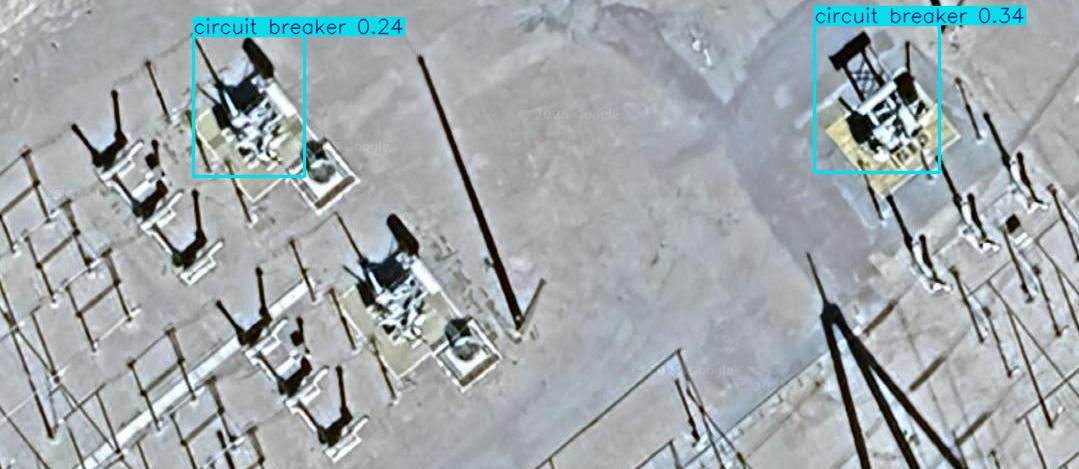

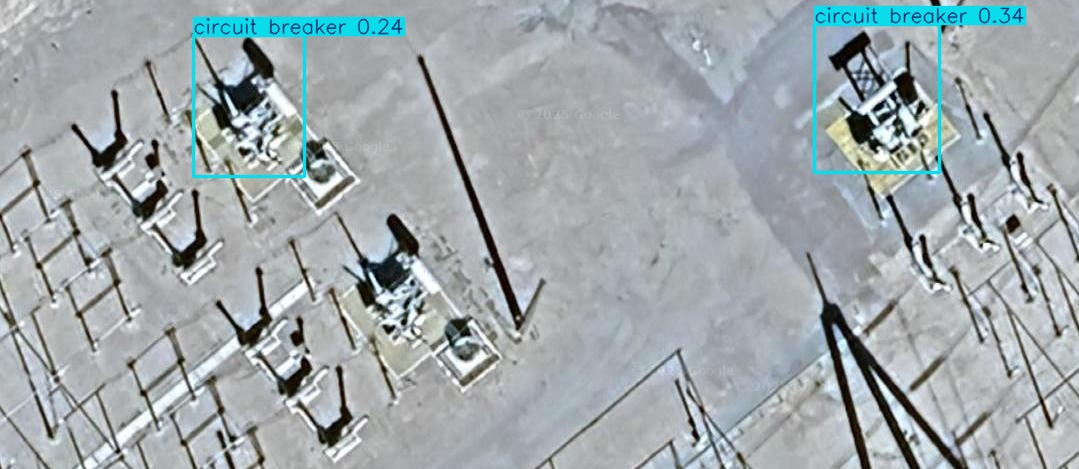

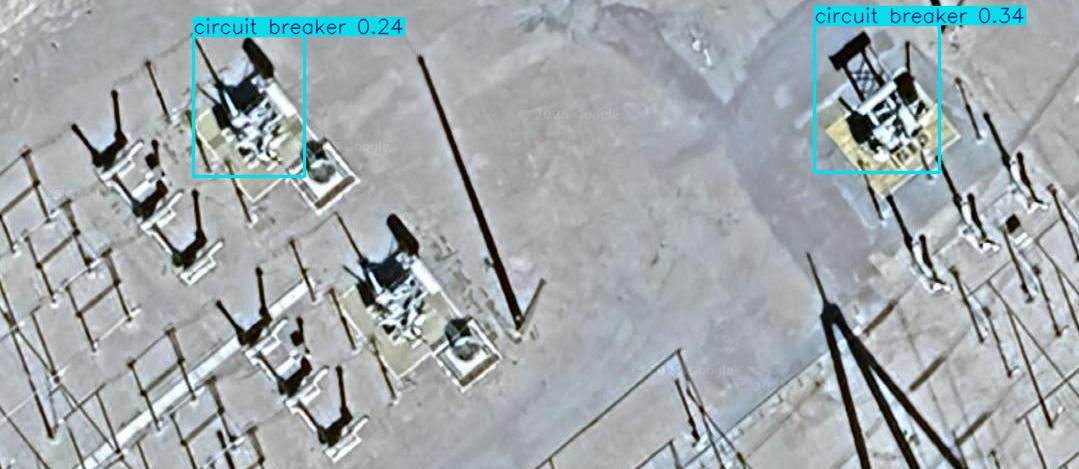

In [55]:
# show results on an image
import random
from IPython.display import Image as IPyImage, display

test_images = "/content/dataset/images/test"

# pick a random image
image_files = [f for f in os.listdir(test_images) if f.endswith(('.jpg', '.png'))]
random_image = random.choice(image_files)
random_image_path = os.path.join(test_images, random_image)

# Run inference
results = model(random_image_path, conf=0.50)

# Show the prediction (inline in Colab/Jupyter)
results[0].show()  # visualize with bounding boxes

# Optional: display it in Colab cleanly
display(IPyImage(filename=results[0].save(filename="pred.jpg")))
results[0].show()

In [50]:
# predict on test set/calculate accuracy
import os

test_dir = "dataset/images/val/"
images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(".jpg")]

score = 0
total = 0

for img_path in images:
    results = model(img_path)[0]
    for box in results.boxes:
        cls_id = int(box.cls)
        score += float(box.conf)
    total += 1  # crude accuracy = 1 per image (not per box)

print(f"Rough accuracy: {score}/{total} = {score/total:.2%}")


image 1/1 /content/dataset/images/val/Screenshot-2025-07-01-at-8_38_32-PM_png.rf.1b7cf5bf05b30af3f7193757809d9983.jpg: 640x448 (no detections), 215.9ms
Speed: 6.7ms preprocess, 215.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/dataset/images/val/Screenshot-2025-07-01-at-8_39_19-PM_png.rf.cf895b5601f144950fde7cc71b31fbcd.jpg: 416x640 (no detections), 152.0ms
Speed: 3.3ms preprocess, 152.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/dataset/images/val/Screenshot-2025-07-01-at-9_43_51-PM_png.rf.31be682a3a08b543605293570ed17f5f.jpg: 640x608 (no detections), 229.4ms
Speed: 4.9ms preprocess, 229.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /content/dataset/images/val/Screenshot-2025-07-01-at-9_44_05-PM_png.rf.a7dc71caa695b8a591ac2f204e9d64f6.jpg: 640x512 2 circuit breakers, 203.2ms
Speed: 4.7ms preprocess, 203.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640